# AntiFungalML

## Description
This is a script for the data analysis and training machine learning models

#### Data Analysis:
    1. Lipinski property calculation and comparison between positive and negative dataset
    2. Perform PCA analysis to show if PCA can explain the differences between positive and negative sets
    3. Perform tSNE and uMAP analysis to explain the differences between positive and negative sets
    4. Difference between the chemical classes in positive and negative sets

#### ML models
    a. Random Forest
    b. Gradient Boosting Tree
    c. Support vector machine
    d. Deep Neural Network
<br></br>

### Data Analysis

#### Step 1: Lipinski Property Calculations

In [19]:
# Lipinski Properties Calculation of Postive dataset

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit import RDLogger

# Only show critical warnings
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

# Define a function for Lipinski Property Calculation
def LipinskiPropertyCalculation(sdfFile):
    
    # Load the sdfFile
    suppl = Chem.SDMolSupplier(sdfFile)
    
    # Check if any molecule is empty
    mols = [mol for mol in suppl if mol is not None]
    
    # Extract desired properties into a list of dictionaries
    data = list()
    names = list()
    
    
    for mol in mols:
        if mol is not None:
            name = mol.GetProp("Name")
            names.append(name)
     
        # Append all the properties in the data list 
        data.append({
            'SMILES': Chem.MolToSmiles(mol),
            'Name':  name,
            'MolecularWeight': Descriptors.MolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'HBD': Descriptors.NumHDonors(mol),
            'HBA': Descriptors.NumHAcceptors(mol)
        })
    return data


if __name__=='__main__':

    # Give the name of the sdf file
    sdfFile = '/work/gsriva2/MLProject_MP_KM_AM/Antifungal-Positive.sdf'
    
    # Run the calculations
    data = LipinskiPropertyCalculation(sdfFile)
    
    # Create a pandas DataFrame from the data
    data = pd.DataFrame.from_dict(data)

    # Save the data into a TSV file
    data.to_csv('/work/gsriva2/MLProject_MP_KM_AM/Antifungal_Positive_LipinskiProperties.tsv', sep='\t', index=False)


In [18]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
from rdkit import RDLogger

# Only show critical warnings
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

def SMILES2CanonicalSMILES(infile):
	
	# Load the SMILES data
	data = pd.read_csv(infile)

	# Iterate over each row
	for id, row in data.iterrows():
		smiles = row['SMILES']
		# Read smiles and check if they are valid canonical smiles or not
		try:
			CanonicalSmiles = Chem.CanonSmiles(smiles)
			data.loc[id, "CanonicalSMILES"] = CanonicalSmiles
		except:
			data.loc[id, "CanonicalSMILES"] = "Not a valid SMILES"
	return data

def CalculateLipinskiRule(data):
	
	# Initialize lists to store Lipinski properties
	mw, logp, hbd, hba = [], [], [], []
	# Iterate over each row
	for _, row in data.iterrows():
		smiles = row.SMILES
		# Read smiles and check if they are valid canonical smiles or not
		try:
			mol = Chem.MolFromSmiles(smiles)
			if mol:
				# Calculate Lipinski properties
				mw.append(Descriptors.MolWt(mol))
				logp.append(Descriptors.MolLogP(mol))
				hbd.append(Descriptors.NumHDonors(mol))
				hba.append(Descriptors.NumHAcceptors(mol))
			else:
				mw.append(None)
				logp.append(None)
				hbd.append(None)
				hba.append(None)
		except:
			mw.append(None)
			logp.append(None)
			hbd.append(None)
			hba.append(None)
	
	# Add Lipinski properties to the DataFrame
	# 1. Molecular Weight
	data['MolecularWeight'] = mw
	# 2. Water Octanol partition coefficient
	data['LogP'] = logp
	# 3. Hydrogen Bond Donors
	data['HBD'] = hbd
	# 4. Hydrogen Bond Acceptor
	data['HBA'] = hba
	
	return data


if __name__=="__main__":
    
    inputFilePath = '/work/gsriva2/MLProject_MP_KM_AM'
    
    data = SMILES2CanonicalSMILES(f'{inputFilePath}/Antifungal-Negative.csv')
    
    data = CalculateLipinskiRule(data)
    
    data.to_csv(f'{inputFilePath}/Antifungal_Negative_LipinskiProperties.tsv', sep="\t", index=False)
	


[00:24:46] Explicit valence for atom # 21 N, 4, is greater than permitted
[00:24:47] Explicit valence for atom # 1 Cl, 4, is greater than permitted
[00:24:51] Explicit valence for atom # 21 N, 4, is greater than permitted
[00:24:52] Explicit valence for atom # 1 Cl, 4, is greater than permitted


#### Step 3: Plot Lipinski Properties comparing the two groups (positive and negative) with p value 

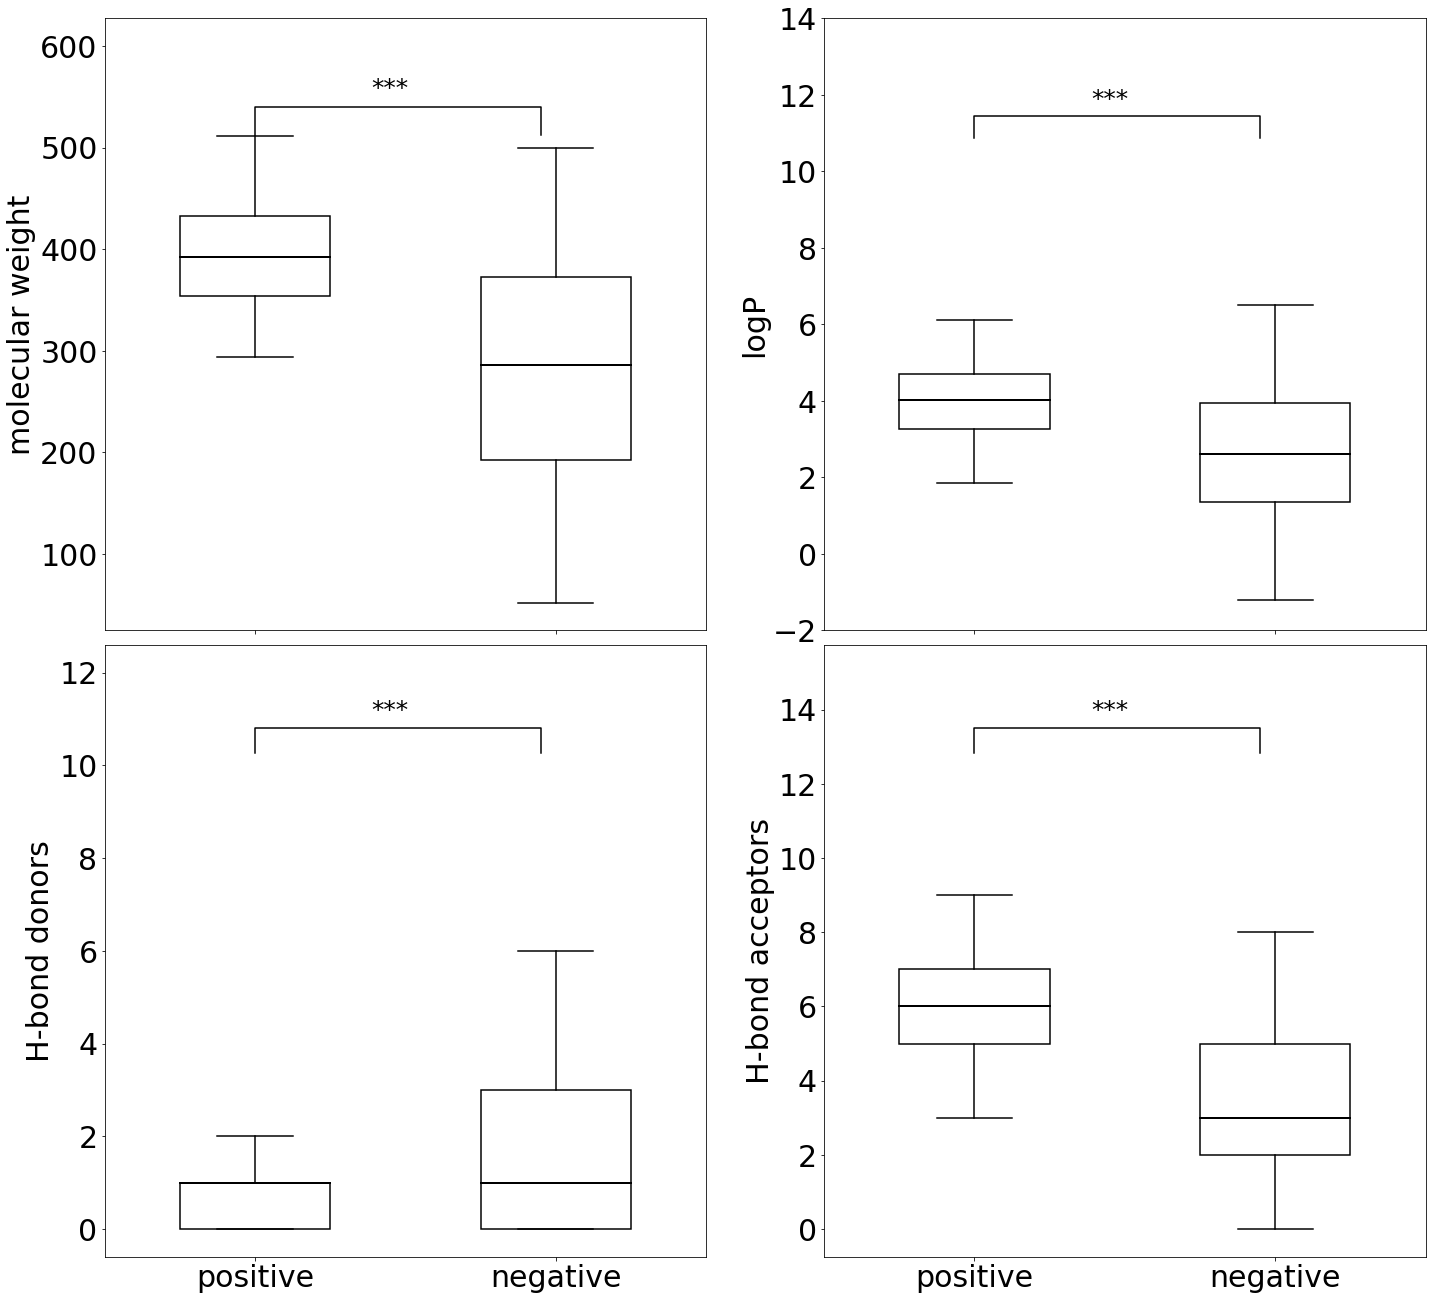

In [101]:
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the positive dataset
positive_data = pd.read_csv('/work/gsriva2/MLProject_MP_KM_AM/Antifungal_Positive_LipinskiProperties.tsv', sep='\t')
positive_data['Category'] = 'positive'

# Load the negative dataset
negative_data = pd.read_csv('/work/gsriva2/MLProject_MP_KM_AM/Antifungal_Negative_LipinskiProperties.tsv', sep='\t')
negative_data['Category'] = 'negative'
negative_data = negative_data.rename(columns={'NAME': 'Name'})
negative_data = negative_data[['SMILES', 'Name', 'MolecularWeight', 'LogP', 'HBD', 'HBA', 'Category']]

# Combine datasets
combined_data = pd.concat([positive_data, negative_data])

# Convert numeric columns to float
numeric_columns = ["MolecularWeight", "LogP", "HBD", "HBA"]
combined_data[numeric_columns] = combined_data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Drop NaN values from numeric columns
combined_data = combined_data.dropna(subset=numeric_columns)

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(20, 18), sharex=True)
fig.subplots_adjust(wspace=0.3)

# Define properties and corresponding axes
properties = ["MolecularWeight", "LogP", "HBD", "HBA"]
titles = ["molecular weight", "logP", "H-bond donors", "H-bond acceptors"]

# Significance thresholds
thresholds = {0.001: "***", 0.01: "**", 0.05: "*", 0.1: "•"}

# Perform t-tests and plot
for i, (prop, title) in enumerate(zip(properties, titles)):
    row, col = divmod(i, 2)  # Determine subplot position

    # Extract values
    pos_values = combined_data[combined_data["Category"] == "positive"][prop].dropna()
    neg_values = combined_data[combined_data["Category"] == "negative"][prop].dropna()

    # Check for zero variance
    significance_label = ""
    if pos_values.var() == 0 or neg_values.var() == 0:
        p_value = np.nan  # If variance is zero, t-test is invalid
    else:
        t_stat, p_value = ttest_ind(pos_values, neg_values, equal_var=False)

        # Assign significance label
        for threshold, label in thresholds.items():
            if p_value < threshold:
                significance_label = label
                break

    # Plot boxplot with customized style
    sns.boxplot(
        x="Category", y=prop, data=combined_data, ax=axes[row, col], width=0.5, fliersize=0,
        boxprops={'facecolor': 'none', 'edgecolor': 'black'},
        whis=1,
        whiskerprops={'color': 'black', 'linestyle': '-', 'linewidth': 1.5},
        capprops={'color': 'black', 'linewidth': 1.5},
        medianprops={'color': 'black', 'linewidth': 2}
    )
    
    axes[row, col].set_xlabel("")
    axes[row, col].set_ylabel(title, fontsize=30)
    axes[row,col].tick_params(axis='both', which='major', labelsize=30)

    # Draw significance arrow only if valid p-value
    if significance_label:
        y_max = max(pos_values.max(), neg_values.max()) * 0.9  # Get max y value for annotation
        axes[row, col].plot([0, 0, 0.95, 0.95], [y_max * 0.95, y_max, y_max, y_max * 0.95], lw=1.5, color='black')
        axes[row, col].text(0.45, y_max * 1.02, significance_label, ha='center', fontsize=25, color='black')

#axes[0,0].set_ylim(100,600)
axes[0,1].set_ylim(-2, 14)
#axes[1,0].set_ylim(-1,8)

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig('lipinskiproperties.png', 
        dpi=600, 
        format='png', 
        pil_kwargs={"compression": "png_lzw"}
    )


### ML Trainng
#### Step 1: Random Forest

5-Fold Cross Validation Metrics:

Fold 1:
  Accuracy: 0.9287
  Balanced Accuracy: 0.9238
  Precision: 0.9195
  Recall: 0.9586
  F1 Score: 0.9387
  ROC AUC: 0.9710
  MCC: 0.8546

Fold 2:
  Accuracy: 0.9338
  Balanced Accuracy: 0.9291
  Precision: 0.9240
  Recall: 0.9629
  F1 Score: 0.9430
  ROC AUC: 0.9707
  MCC: 0.8651

Fold 3:
  Accuracy: 0.9242
  Balanced Accuracy: 0.9189
  Precision: 0.9136
  Recall: 0.9575
  F1 Score: 0.9350
  ROC AUC: 0.9636
  MCC: 0.8456

Fold 4:
  Accuracy: 0.9287
  Balanced Accuracy: 0.9233
  Precision: 0.9170
  Recall: 0.9617
  F1 Score: 0.9388
  ROC AUC: 0.9710
  MCC: 0.8547

Fold 5:
  Accuracy: 0.9242
  Balanced Accuracy: 0.9190
  Precision: 0.9145
  Recall: 0.9563
  F1 Score: 0.9349
  ROC AUC: 0.9634
  MCC: 0.8455

Mean Cross Validation Metrics:
  Mean Accuracy: 0.9279
  Mean Balanced Accuracy: 0.9228
  Mean Precision: 0.9177
  Mean Recall: 0.9594
  Mean F1 Score: 0.9381
  Mean ROC AUC: 0.9680
  Mean MCC: 0.8531


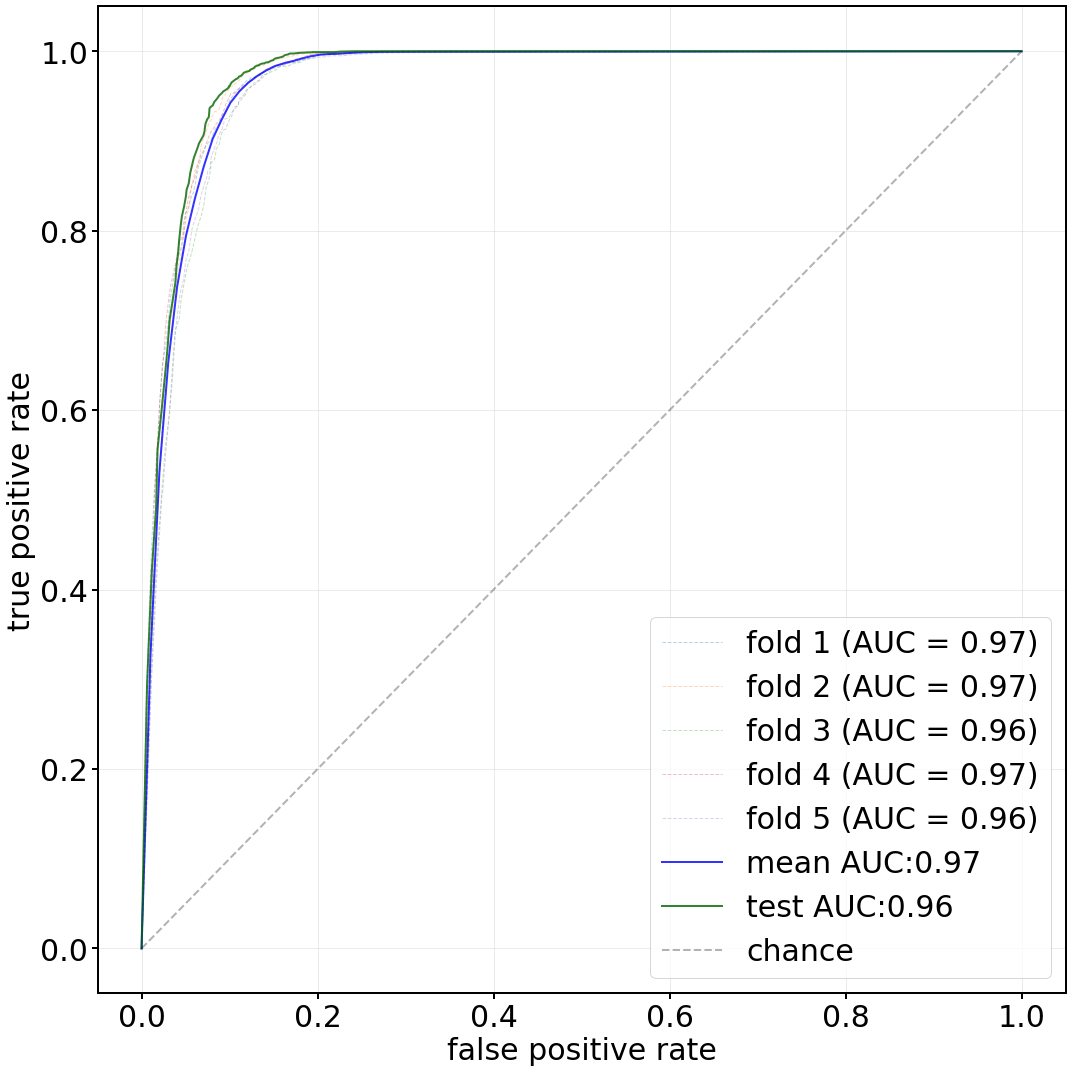


Test Set Evaluation Metrics:
  Accuracy: 0.9356
  Balanced Accuracy: 0.9312
  Precision: 0.9264
  Recall: 0.9635
  F1 Score: 0.9446
  ROC AUC: 0.9731
  MCC: 0.8689

Confusion Matrix:
[[2177  245]
 [ 117 3086]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2422
           1       0.93      0.96      0.94      3203

    accuracy                           0.94      5625
   macro avg       0.94      0.93      0.93      5625
weighted avg       0.94      0.94      0.94      5625


Model saved as 'random_forest_model.joblib'.


In [109]:
import pandas as pd
import numpy as np
import joblib
import random
import matplotlib.pyplot as plt

#from scipy import interp  # For interpolation of TPR values (if using older numpy, otherwise use np.interp)
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, classification_report,
                             matthews_corrcoef, balanced_accuracy_score, make_scorer)

# Seed for reproducibility
random.seed(42)


#Load the classification data
df = pd.read_csv('/work/gsriva2/MLProject_MP_KM_AM/combined_data.csv')

# Select only numerical features for scaling
numerical_features = ['MolecularWeight', 'LogP', 'NumHDonors', 'NumHAcceptors']
X = df[numerical_features].values
y = df.iloc[:, -1].values

# Split data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y)

# Scale numerical features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# --------------------------
# Model and Cross Validation Metrics
# --------------------------
classifier = RandomForestClassifier(n_estimators=100, random_state=0)

# Define custom scorer for MCC
mcc_scorer = make_scorer(matthews_corrcoef)

# Define scoring metrics including balanced accuracy
scoring = {
    'accuracy': 'accuracy',
    'balanced_accuracy': 'balanced_accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'mcc': mcc_scorer
}

# Perform 5-fold cross validation on the training set
cv_results = cross_validate(classifier, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)

# Print metrics for each fold
print("5-Fold Cross Validation Metrics:")
for i in range(5):
    print(f"\nFold {i+1}:")
    print(f"  Accuracy: {cv_results['test_accuracy'][i]:.4f}")
    print(f"  Balanced Accuracy: {cv_results['test_balanced_accuracy'][i]:.4f}")
    print(f"  Precision: {cv_results['test_precision'][i]:.4f}")
    print(f"  Recall: {cv_results['test_recall'][i]:.4f}")
    print(f"  F1 Score: {cv_results['test_f1'][i]:.4f}")
    print(f"  ROC AUC: {cv_results['test_roc_auc'][i]:.4f}")
    print(f"  MCC: {cv_results['test_mcc'][i]:.4f}")

# Calculate and print mean metrics across folds
mean_accuracy = np.mean(cv_results['test_accuracy'])
mean_bal_accuracy = np.mean(cv_results['test_balanced_accuracy'])
mean_precision = np.mean(cv_results['test_precision'])
mean_recall = np.mean(cv_results['test_recall'])
mean_f1 = np.mean(cv_results['test_f1'])
mean_roc_auc = np.mean(cv_results['test_roc_auc'])
mean_mcc = np.mean(cv_results['test_mcc'])

print("\nMean Cross Validation Metrics:")
print(f"  Mean Accuracy: {mean_accuracy:.4f}")
print(f"  Mean Balanced Accuracy: {mean_bal_accuracy:.4f}")
print(f"  Mean Precision: {mean_precision:.4f}")
print(f"  Mean Recall: {mean_recall:.4f}")
print(f"  Mean F1 Score: {mean_f1:.4f}")
print(f"  Mean ROC AUC: {mean_roc_auc:.4f}")
print(f"  Mean MCC: {mean_mcc:.4f}")

# --------------------------
# ROC Curve Plot for Each Fold & Mean ROC
# --------------------------
# We use StratifiedKFold to generate ROC curves per fold
cv = StratifiedKFold(n_splits=5)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(15, 15))
i = 0

for train_index, test_index in cv.split(X_train, y_train):
    X_cv_train, X_cv_test = X_train[train_index], X_train[test_index]
    y_cv_train, y_cv_test = y_train[train_index], y_train[test_index]

    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(X_cv_train, y_cv_train)
    y_cv_proba = clf.predict_proba(X_cv_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_cv_test, y_cv_proba)
    roc_auc = roc_auc_score(y_cv_test, y_cv_proba)
    aucs.append(roc_auc)

    # Interpolate tpr at common mean_fpr values
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

    plt.plot(fpr, tpr, lw=1, linestyle='--', label=f'fold {i+1} (AUC = {roc_auc:.2f})', alpha=0.3)
    i += 1

# Plot mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = roc_auc_score(y, classifier.fit(X_train, y_train).predict_proba(X)[:, 1])
plt.plot(mean_fpr, mean_tpr, color='b', lw=2, label=f'mean AUC:{np.mean(aucs):.2f}', alpha=0.8)


# --------------------------
# Final Model Training and Test Evaluation
# --------------------------
# Train classifier on the full training set
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)[:, 1]  # For ROC AUC
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba)
roc_auc_test = roc_auc_score(y_cv_test, y_cv_proba)
plt.plot(fpr_test, tpr_test, color='darkgreen', lw=2, label=f'test AUC:{np.mean(roc_auc_test):.2f}', alpha=0.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='chance', alpha=0.3)

plt.xlabel('false positive rate', fontsize=30)
plt.ylabel('true positive rate', fontsize=30)
plt.legend(loc="lower right", fontsize=30)
plt.grid(alpha=0.3)
plt.tick_params(axis='both', which='major', length=6, width=2, labelsize=30)
plt.tight_layout()

# Accessing and modifying the top spine
ax = plt.gca()  # Get the current axes
ax.spines['top'].set_linewidth(2)  # Hide the top spine
ax.spines['top'].set_color('black')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('black')

plt.savefig('RandomForest.png', dpi=600, pil_kwargs={'compression':'png_lzw'} )
plt.show()


# Compute metrics on test set
test_acc = accuracy_score(y_test, y_pred)
test_bal_acc = balanced_accuracy_score(y_test, y_pred)
test_prec = precision_score(y_test, y_pred)
test_rec = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)
test_mcc = matthews_corrcoef(y_test, y_pred)

print("\nTest Set Evaluation Metrics:")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Balanced Accuracy: {test_bal_acc:.4f}")
print(f"  Precision: {test_prec:.4f}")
print(f"  Recall: {test_rec:.4f}")
print(f"  F1 Score: {test_f1:.4f}")
print(f"  ROC AUC: {test_auc:.4f}")
print(f"  MCC: {test_mcc:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --------------------------
# Save the final trained model
# --------------------------
joblib.dump(classifier, 'random_forest_model.joblib')
print("\nModel saved as 'random_forest_model.joblib'.")